<a href="https://colab.research.google.com/github/Kamruzzaman2200/Datamining/blob/main/K_medoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Minimal imports and settings

In [2]:

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

# Optional: make plots a bit larger by default
plt.rcParams['figure.figsize'] = (9,6)


#Set file path and quick check

In [3]:

csv_path = '/content/drive/MyDrive/DataSets/kc_house_data.csv'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Dataset not found at {csv_path}. Upload file to Colab or update csv_path.")
print("Found dataset at:", csv_path)


Found dataset at: /content/drive/MyDrive/DataSets/kc_house_data.csv


#Load dataset

In [4]:

df = pd.read_csv(csv_path)
print("Loaded dataset shape:", df.shape)
display(df.head())


Loaded dataset shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#Simple preprocessing: select numeric, drop id, drop NA, scale

In [5]:

numeric = df.select_dtypes(include=[np.number]).copy()

# Drop typical ID columns if present
for id_col in ['id', 'Id']:
    if id_col in numeric.columns:
        numeric.drop(columns=[id_col], inplace=True)

# Drop rows with NA in numeric subset (simple, robust)
numeric = numeric.dropna(axis=0).copy()
print("Numeric features used (count):", len(numeric.columns))
print("Numeric data shape after dropna:", numeric.shape)

# Scale features (StandardScaler)
scaler = StandardScaler()
X = scaler.fit_transform(numeric.values)   # scaled matrix used for clustering


Numeric features used (count): 19
Numeric data shape after dropna: (21613, 19)


#Parameters for clustering (change these if you want)

In [6]:
n_clusters = 3       # desired number of clusters
max_sample = 1000    # sample size used to find medoids; reduce to 500 if memory issues
random_state = 42
max_iter_pam = 100


#PAM (sampled medoid search) + full assignment function

In [7]:
import numpy as np

def pam_sample_assign_full(X, k, max_sample=1000, random_state=42, max_iter=100):
    """
    1) Sample up to max_sample rows to find medoids (PAM within-sample).
    2) Convert medoid indices to full dataset indices and assign every row in X
       to the nearest medoid (so the full dataset is labeled).
    Returns:
      labels_full : ndarray shape (n,)  - cluster labels for all rows
      medoids_full : ndarray - indices of medoids in the full X space
    """
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    if n > max_sample:
        sample_idx = rng.choice(n, max_sample, replace=False)
        Xs = X[sample_idx]
        print(f"Sampling {max_sample}/{n} rows for medoid search.")
    else:
        sample_idx = np.arange(n)
        Xs = X
        print(f"Using full data of {n} rows for medoid search.")

    m = Xs.shape[0]
    medoids = rng.choice(m, k, replace=False)

    for it in range(max_iter):
        # assign sample points to nearest medoid
        dists = np.linalg.norm(Xs[:, None, :] - Xs[medoids][None, :, :], axis=2)  # m x k
        labels_s = np.argmin(dists, axis=1)
        changed = False
        for c in range(k):
            members = np.where(labels_s == c)[0]
            if len(members) == 0:
                continue
            cluster_points = Xs[members]
            # compute pairwise distances inside cluster
            pairwise = np.linalg.norm(cluster_points[:, None, :] - cluster_points[None, :, :], axis=2)
            costs = pairwise.sum(axis=1)
            best_in_members = np.argmin(costs)
            best = members[best_in_members]
            if medoids[c] != best:
                medoids[c] = best
                changed = True
        if not changed:
            print(f"PAM converged after {it+1} iterations.")
            break
    else:
        print(f"PAM stopped after max_iter={max_iter} without full convergence.")

    medoids_full = sample_idx[medoids]  # convert medoid indices from sample to full indexing
    # assign every row in full X to nearest medoid
    d_full = np.linalg.norm(X[:, None, :] - X[medoids_full][None, :, :], axis=2)  # n x k
    labels_full = np.argmin(d_full, axis=1)
    return labels_full, medoids_full


#Run clustering (this cell runs the function)

In [8]:
labels_full, medoids_full = pam_sample_assign_full(X, k=n_clusters, max_sample=max_sample,
                                                   random_state=random_state, max_iter=max_iter_pam)
print("Medoids (indices in numeric array):", medoids_full)
(unique, counts) = np.unique(labels_full, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))


Sampling 1000/21613 rows for medoid search.
PAM converged after 3 iterations.
Medoids (indices in numeric array): [11491 12620   812]
Cluster counts: {np.int64(0): np.int64(9445), np.int64(1): np.int64(6631), np.int64(2): np.int64(5537)}


#Map labels back to original DataFrame, save result

In [9]:
result = df.copy()
# numeric.index indicates which original rows were used (we dropped NA earlier)
result.loc[numeric.index, 'kmedoids_label'] = labels_full

out_path = '/content/kc_house_data_kmedoids.csv'
result.to_csv(out_path, index=False)
print(f"Saved labelled dataset to: {out_path}")
display(result[['price','sqft_living','lat','long','kmedoids_label']].head(12))


Saved labelled dataset to: /content/kc_house_data_kmedoids.csv


,price,sqft_living,lat,long,kmedoids_label
0,221900.0,1180,47.5112,-122.257,0.0
1,538000.0,2570,47.7210,-122.319,2.0
2,180000.0,770,47.7379,-122.233,0.0
3,604000.0,1960,47.5208,-122.393,0.0
4,510000.0,1680,47.6168,-122.045,2.0
5,1225000.0,5420,47.6561,-122.005,1.0
6,257500.0,1715,47.3097,-122.327,2.0
7,291850.0,1060,47.4095,-122.315,0.0
8,229500.0,1780,47.5123,-122.337,0.0
9,323000.0,1890,47.3684,-122.031,2.0


#Quick 2D PCA plot of clusters

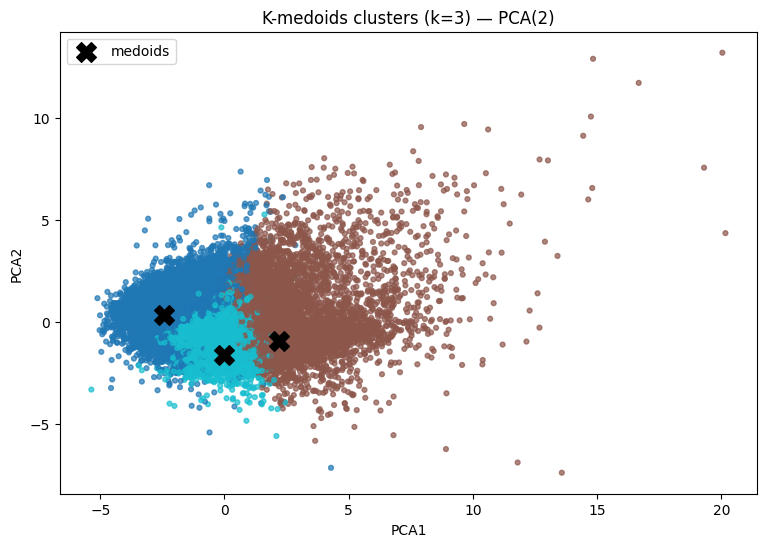

Explained variance by PCA(2): [0.29870605 0.12710777]


In [10]:
# We'll plot all rows used in numeric (labels_full).
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(9,6))
plt.scatter(X2[:,0], X2[:,1], c=labels_full, s=12, cmap='tab10', alpha=0.7)
plt.scatter(X2[medoids_full,0], X2[medoids_full,1], s=200, c='black', marker='X', label='medoids')
plt.title(f'K-medoids clusters (k={n_clusters}) — PCA(2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

print("Explained variance by PCA(2):", pca.explained_variance_ratio_)
